In [97]:
!pip install --upgrade jax==0.5.1 jaxlib==0.5.1
!pip install jaxkan diffrax

In [111]:
import jax
import jaxlib
import jax.numpy as jnp
import diffrax
import numpy as np
import matplotlib.pyplot as plt
from jaxkan.KAN import KAN
from flax import nnx
import optax
import time
from google.colab import files
import scipy.io
from scipy.interpolate import interp1d

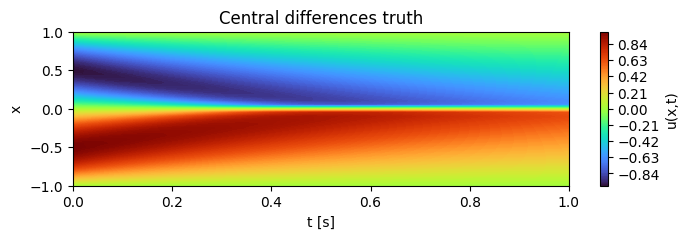

In [99]:
# Central differences truth:

x_min, x_max = -1.0, 1.0
t_min, t_max = 0.0, 1.0

dx = 0.05
dt = 0.01

xgrid = jnp.arange(x_min, x_max + dx, dx)
tgrid = jnp.arange(t_min, t_max + dt, dt)

u0 = - jnp.sin(jnp.pi * xgrid)

def vector_field(t, u, args):

    dx = args

    dudx = (u - jnp.roll(u, 1)) / dx * (u > 0) + (jnp.roll(u, -1) - u) / dx * (u < 0)
    d2udx2 = (jnp.roll(u, -1) - 2 * u + jnp.roll(u, 1)) / dx**2

    du_dt = -u * dudx + (0.01/jnp.pi) * d2udx2

    du_dt = du_dt.at[0].set(0)
    du_dt = du_dt.at[-1].set(0)

    return du_dt

solver = diffrax.Tsit5()

stepsize_controller = diffrax.PIDController(rtol = 1e-4, atol = 1e-6)
term = diffrax.ODETerm(vector_field)
saveat = diffrax.SaveAt(ts = tgrid)

solution = diffrax.diffeqsolve(term, solver, t0 = t_min, t1 = t_max, dt0 = dt, y0 = u0, args = dx, saveat = saveat, stepsize_controller = stepsize_controller)

U = jnp.array(solution.ys).T

plt.figure(figsize = (8, 2))
plt.contourf(tgrid, xgrid, U, levels = 201, cmap = "turbo")
plt.colorbar(label = "u(x,t)")
plt.xlabel("t [s]")
plt.ylabel("x")
plt.title("Central differences truth")
plt.show()

Saving burgers.mat to burgers (2).mat
dict_keys(['__header__', '__version__', '__globals__', 'nu', 't', 'usol', 'x'])
nu: 0.003183098861837907
x shape: (512,), t shape: (201,), usol shape: (201, 512)


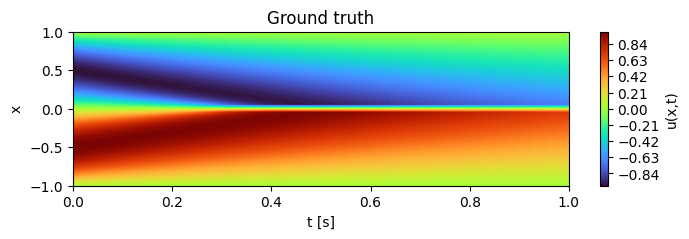

In [100]:
# Ground truth:

uploaded = files.upload()
data = scipy.io.loadmat('burgers.mat')

print(data.keys())

nu = data['nu'].item()
x = data['x'].squeeze()
t = data['t'].squeeze()
usol = data['usol']

print(f"nu: {nu}")
print(f"x shape: {x.shape}, t shape: {t.shape}, usol shape: {usol.shape}")

# Aggregation:

x_new = xgrid
usol_new = np.zeros((len(t), len(x_new)))

for i in range(len(t)):
    f = interp1d(x, usol[i, :], kind = 'linear', fill_value = 'extrapolate')
    usol_new[i, :] = f(x_new)

usol = usol_new.T
x = x_new

plt.figure(figsize = (8, 2))
plt.contourf(t, x, usol, levels = 201, cmap = "turbo")
plt.colorbar(label = "u(x,t)")
plt.xlabel("t [s]")
plt.ylabel("x")
plt.title("Ground truth")
plt.show()

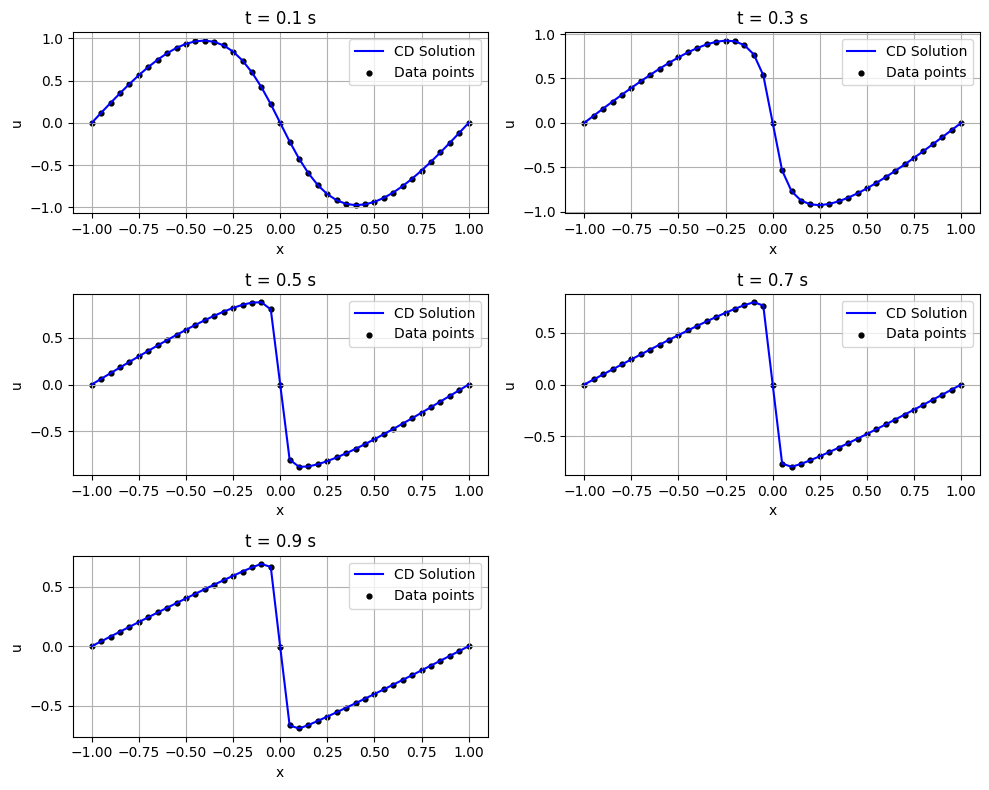

In [101]:
# Training and test data (cd):

t_train = jnp.array([0.1, 0.3, 0.5, 0.7, 0.9])
t_test = jnp.array([0.2, 0.4, 0.6, 0.8, 1.0])

train_data_cd = jnp.zeros((len(t_train), len(xgrid)))
test_data_cd = jnp.zeros((len(t_test), len(xgrid)))

for i, time in enumerate(t_train):
    idx = jnp.abs(tgrid - time).argmin()
    train_data_cd = train_data_cd.at[i, :].set(U[:, idx])

for i, time in enumerate(t_test):
    idx = jnp.abs(tgrid - time).argmin()
    test_data_cd = test_data_cd.at[i, :].set(U[:, idx])

# Plotting training data:

plt.figure(figsize = (10, 8))

for i, time in enumerate(t_train):

    plt.subplot(3, 2, i + 1)
    plt.plot(xgrid, train_data_cd[i,:], label = "CD Solution", color = "b")
    plt.scatter(xgrid, train_data_cd[i,:], color = "black", s = 12, label = "Data points")
    plt.xlabel("x")
    plt.ylabel("u")
    plt.title(f"t = {time:.1} s")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

In [102]:
# Test data (ground truth):

t_test = jnp.array([0.2, 0.4, 0.6, 0.8, 1.0])
test_data_gt = jnp.zeros((len(t_test), len(x)))

for i, time in enumerate(t_test):
    idx = jnp.abs(t - time).argmin()
    test_data_gt = test_data_gt.at[i, :].set(usol[:, idx])

In [103]:
# Models definitions:

class dF(nnx.Module):

    def __init__(self, dy_dt):
        self.dy_dt = dy_dt
    def __call__(self, t, y, args):
        y = y[jnp.newaxis, :]
        return self.dy_dt(y)[0]

class MLP(nnx.Module):

    def __init__(self, layer_dims, rngs: nnx.Rngs):

        self.layers = [
            nnx.Linear(layer_dims[i], layer_dims[i + 1], rngs = rngs)
            for i in range(len(layer_dims) - 1)]

    def __call__(self, t,y,args):

        for layer in self.layers[:-1]:
            y = layer(y)
            y = jnp.tanh(y)

        y = self.layers[-1](y)

        return y

class NODE(nnx.Module):

    def __init__(self,dF):
        self.dF = dF

    def __call__(self, ts, y0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.dF),
            diffrax.Tsit5(),
            t0 = t_min,
            t1 = t_max,
            dt0 = dt,
            y0 = y0,
            stepsize_controller = diffrax.PIDController(rtol = 1e-4, atol = 1e-6),
            saveat = diffrax.SaveAt(ts = ts),
        )
        return solution.ys

In [104]:
# Loss function:

def loss_fn(model, t, u_0, u_true):
    u_pred = model(t, u_0)
    return jnp.mean((u_pred - u_true) ** 2)

# Optimizer:

opt_type = optax.adam(learning_rate = 0.001)

In [105]:
# L2 relative error:

def l2_relative_error(y_pred, y_true):
    numerator = jnp.linalg.norm(y_pred - y_true)
    denominator = jnp.linalg.norm(y_true)
    return numerator / denominator

In [106]:
# Training step:

@nnx.jit
def train_step(model, optimizer, t_train, u0_train, u_train):

    train_loss, grads = nnx.value_and_grad(loss_fn)(model, t_train, u0_train, u_train)
    optimizer.update(grads)

    return train_loss

# Test step:

@nnx.jit
def test_step(model, optimizer, t_train, u0_train, u_train, t_test, u_test, tgrid, U):

    train_loss, grads = nnx.value_and_grad(loss_fn)(model, t_train, u0_train, u_train)
    optimizer.update(grads)
    test_loss = loss_fn(model, t_test, u0_train, u_test)
    l2_error = l2_relative_error(model(tgrid, u0_train), U)

    return train_loss, test_loss, l2_error

In [107]:
# Training function:

def train(model, optimizer, num_epochs = 5000):
    train_losses = jnp.zeros(num_epochs)
    start_time = time.time()

    for epoch in range(num_epochs):
        train_loss = train_step(model, optimizer, t_train, u0, train_data_cd)
        train_losses = train_losses.at[epoch].set(train_loss)

    print(f"Training time: {time.time() - start_time:.1f} seconds")

    return train_losses

In [108]:
# Training (CD truth) / Evaluation (CD truth):

In [109]:
# Test function:

def test(model, optimizer, num_epochs = 5000):

    train_losses = jnp.zeros(num_epochs)
    test_losses = jnp.zeros(num_epochs)
    l2_errors = jnp.zeros(num_epochs)

    for epoch in range(num_epochs):
        train_loss, test_loss, l2_error = test_step(model, optimizer, t_train, u0, train_data_cd, t_test, test_data_cd, tgrid, U.T)
        train_losses = train_losses.at[epoch].set(train_loss)
        test_losses = test_losses.at[epoch].set(test_loss)
        l2_errors = l2_errors.at[epoch].set(l2_error)

    return train_losses, test_losses, l2_errors

In [112]:
# KAN-ODE training: (8251 params)

KAN_model = KAN(
            layer_dims = [41, 10, 41],
            layer_type = 'spline',
            required_parameters = {'G': 5},
           )

dF_model = dF(KAN_model)
KANODE_model = NODE(dF_model)
optimizer = nnx.Optimizer(KANODE_model, opt_type)

train_losses_KANODE = train(KANODE_model, optimizer)

Training time: 143.5 seconds


In [113]:
# KAN-ODE test: (8251 params)

KAN_model = KAN(
            layer_dims = [41, 10, 41],
            layer_type = 'spline',
            required_parameters = {'G': 5},
           )

dF_model = dF(KAN_model)
KANODE_model = NODE(dF_model)
optimizer = nnx.Optimizer(KANODE_model, opt_type)

train_losses_KANODE, test_losses_KANODE, l2_errors_KANODE = test(KANODE_model, optimizer)

In [114]:
# Small-NODE training: (871 params)

MLP_model = MLP([41,10,41], nnx.Rngs(42))

NODE_small_model = NODE(MLP_model)
optimizer = nnx.Optimizer(NODE_small_model, opt_type)

train_losses_NODE_small = train(NODE_small_model, optimizer)

Training time: 48.3 seconds


In [115]:
# Small-NODE test: (871 params)

MLP_model = MLP([41,10,41], nnx.Rngs(42))

NODE_small_model = NODE(MLP_model)
optimizer = nnx.Optimizer(NODE_small_model, opt_type)

train_losses_NODE_small, test_losses_NODE_small, l2_errors_NODE_small = test(NODE_small_model, optimizer)

In [116]:
# Large-NODE training: (8183)

MLP_model = MLP([41,46,46,46,41], nnx.Rngs(42))

NODE_large_model = NODE(MLP_model)
optimizer = nnx.Optimizer(NODE_large_model, opt_type)

train_losses_NODE_large = train(NODE_large_model, optimizer)

Training time: 62.0 seconds


In [117]:
# Large-NODE test: (8183)

MLP_model = MLP([41,46,46,46,41], nnx.Rngs(42))

NODE_large_model = NODE(MLP_model)
optimizer = nnx.Optimizer(NODE_large_model, opt_type)

train_losses_NODE_large, test_losses_NODE_large, l2_errors_NODE_large = test(NODE_large_model, optimizer)

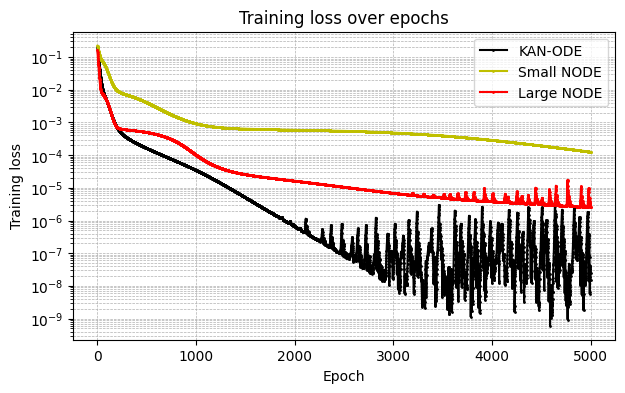

In [118]:
# Training loss:

plt.figure(figsize = (7, 4))

plt.plot(np.array(train_losses_KANODE), label = 'KAN-ODE', marker = 'o', color = '0', markersize = 1)
plt.plot(np.array(train_losses_NODE_small), label = 'Small NODE', marker = 'o', color = 'y', markersize = 1)
plt.plot(np.array(train_losses_NODE_large), label = 'Large NODE', marker = 'o', color = 'r', markersize = 1)

plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.title('Training loss over epochs')
plt.yscale('log')
plt.legend()
plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5)
plt.show()

In [120]:
# Final training losses:

print(f"Final training loss for the KAN-ODE : {train_losses_KANODE[-1]:.8f}")
print(f"Final training loss for the small NODE : {train_losses_NODE_small[-1]:.8f}")
print(f"Final training loss for the large NODE :  {train_losses_NODE_large[-1]:.8f}")

Final training loss for the KAN-ODE : 0.00000001
Final training loss for the small NODE : 0.00012625
Final training loss for the large NODE :  0.00000268


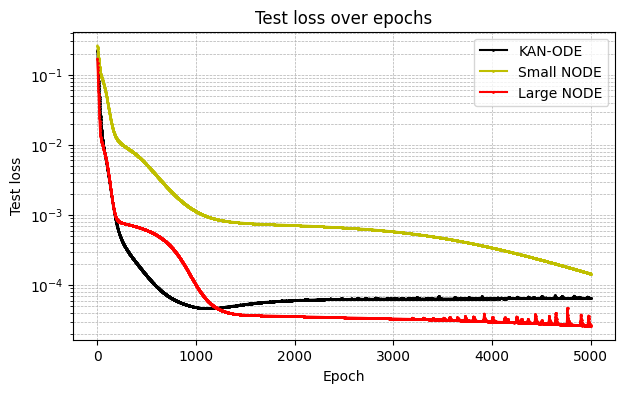

In [121]:
# Test loss:

plt.figure(figsize = (7, 4))

plt.plot(np.array(test_losses_KANODE), label = 'KAN-ODE', marker = 'o', color = '0', markersize = 1)
plt.plot(np.array(test_losses_NODE_small), label = 'Small NODE', marker = 'o', color = 'y', markersize = 1)
plt.plot(np.array(test_losses_NODE_large), label = 'Large NODE', marker = 'o', color = 'r', markersize = 1)

plt.xlabel('Epoch')
plt.ylabel('Test loss')
plt.title('Test loss over epochs')
plt.yscale('log')
plt.legend()
plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5)
plt.show()

In [122]:
# Final test losses:

print(f"Final test loss for the KAN-ODE : {test_losses_KANODE[-1]:.6f}")
print(f"Final test loss for the small NODE : {test_losses_NODE_small[-1]:.6f}")
print(f"Final test loss for the large NODE :  {test_losses_NODE_large[-1]:.6f}")

Final test loss for the KAN-ODE : 0.000065
Final test loss for the small NODE : 0.000145
Final test loss for the large NODE :  0.000027


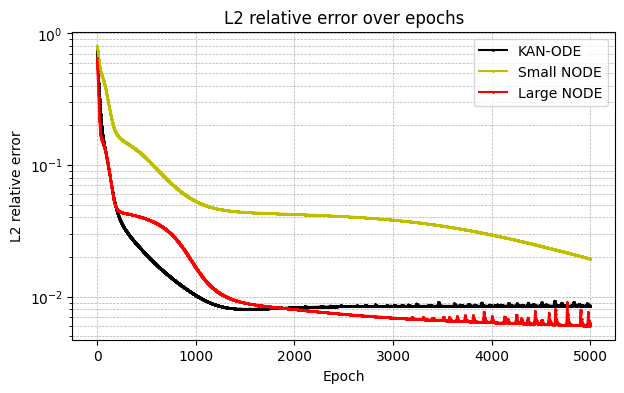

In [123]:
# L2 relative error:

plt.figure(figsize = (7, 4))

plt.plot(np.array(l2_errors_KANODE), label = 'KAN-ODE', marker = 'o', color = '0', markersize = 1)
plt.plot(np.array(l2_errors_NODE_small), label = 'Small NODE', marker = 'o', color = 'y', markersize = 1)
plt.plot(np.array(l2_errors_NODE_large), label = 'Large NODE', marker = 'o', color = 'r', markersize = 1)

plt.xlabel('Epoch')
plt.ylabel('L2 relative error')
plt.title('L2 relative error over epochs')
plt.yscale('log')
plt.legend()
plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5)
plt.show()

In [124]:
# Final L2 relative errors:

print(f"Final L2 relative error for the KAN-ODE : {l2_errors_KANODE[-1]:.4f}")
print(f"Final L2 relative error for the small NODE : {l2_errors_NODE_small[-1]:.4f}")
print(f"Final L2 relative error for the large NODE :  {l2_errors_NODE_large[-1]:.4f}")

Final L2 relative error for the KAN-ODE : 0.0085
Final L2 relative error for the small NODE : 0.0194
Final L2 relative error for the large NODE :  0.0061


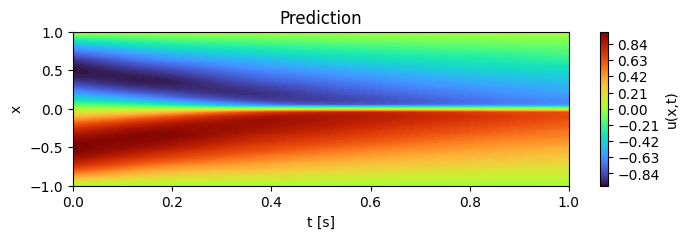

In [125]:
# Entire prediction:

u_pred = KANODE_model(tgrid, u0)

plt.figure(figsize = (8, 2))

plt.contourf(tgrid, xgrid, u_pred.T, levels = 201, cmap = "turbo")
plt.colorbar(label = "u(x,t)")
plt.xlabel("t [s]")
plt.ylabel("x")
plt.title("Prediction")

plt.show()

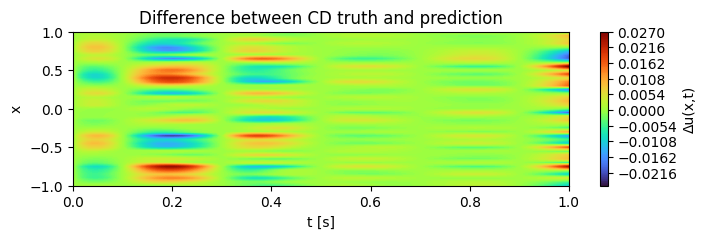

In [126]:
# Difference between CD truth and prediction:

plt.figure(figsize = (8, 2))

plt.contourf(tgrid, xgrid, U - u_pred.T, levels = 201, cmap = "turbo")
plt.colorbar(label = "Δu(x,t)")
plt.xlabel("t [s]")
plt.ylabel("x")
plt.title("Difference between CD truth and prediction")

plt.show()

In [127]:
# Training (CD truth) / Evaluation (ground truth):

In [128]:
# Test function:

def test(model, optimizer, num_epochs = 5000):

    train_losses = jnp.zeros(num_epochs)
    test_losses = jnp.zeros(num_epochs)
    l2_errors = jnp.zeros(num_epochs)

    for epoch in range(num_epochs):
        train_loss, test_loss, l2_error = test_step(model, optimizer, t_train, u0, train_data_cd, t_test, test_data_gt, t, usol.T)
        train_losses = train_losses.at[epoch].set(train_loss)
        test_losses = test_losses.at[epoch].set(test_loss)
        l2_errors = l2_errors.at[epoch].set(l2_error)

    return train_losses, test_losses, l2_errors

In [129]:
# KAN-ODE test: (8251 params)

KAN_model = KAN(
            layer_dims = [41, 10, 41],
            layer_type = 'spline',
            required_parameters = {'G': 5},
           )

dF_model = dF(KAN_model)
KANODE_model = NODE(dF_model)
optimizer = nnx.Optimizer(KANODE_model, opt_type)

train_losses_KANODE, test_losses_KANODE, l2_errors_KANODE = test(KANODE_model, optimizer)

In [130]:
# Small-NODE test: (871 params)

MLP_model = MLP([41,10,41], nnx.Rngs(42))

NODE_small_model = NODE(MLP_model)
optimizer = nnx.Optimizer(NODE_small_model, opt_type)

train_losses_NODE_small, test_losses_NODE_small, l2_errors_NODE_small = test(NODE_small_model, optimizer)

In [131]:
# Large-NODE test: (8183)

MLP_model = MLP([41,46,46,46,41], nnx.Rngs(42))

NODE_large_model = NODE(MLP_model)
optimizer = nnx.Optimizer(NODE_large_model, opt_type)

train_losses_NODE_large, test_losses_NODE_large, l2_errors_NODE_large = test(NODE_large_model, optimizer)

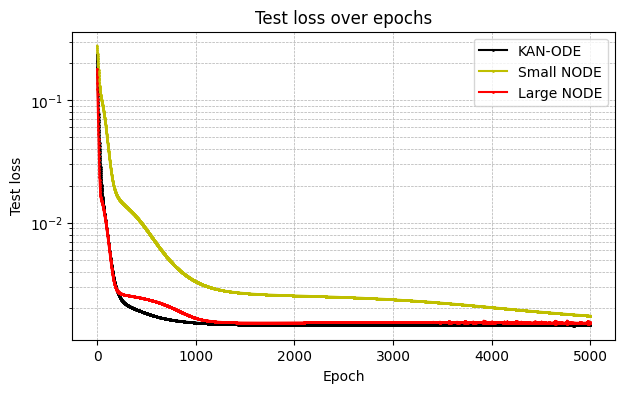

In [132]:
# Test loss:

plt.figure(figsize = (7, 4))

plt.plot(np.array(test_losses_KANODE), label = 'KAN-ODE', marker = 'o', color = '0', markersize = 1)
plt.plot(np.array(test_losses_NODE_small), label = 'Small NODE', marker = 'o', color = 'y', markersize = 1)
plt.plot(np.array(test_losses_NODE_large), label = 'Large NODE', marker = 'o', color = 'r', markersize = 1)

plt.xlabel('Epoch')
plt.ylabel('Test loss')
plt.title('Test loss over epochs')
plt.yscale('log')
plt.legend()
plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5)
plt.show()

In [133]:
# Final test losses:

print(f"Final test loss for the KAN-ODE : {test_losses_KANODE[-1]:.5f}")
print(f"Final test loss for the small NODE : {test_losses_NODE_small[-1]:.5f}")
print(f"Final test loss for the large NODE :  {test_losses_NODE_large[-1]:.5f}")

Final test loss for the KAN-ODE : 0.00148
Final test loss for the small NODE : 0.00174
Final test loss for the large NODE :  0.00154


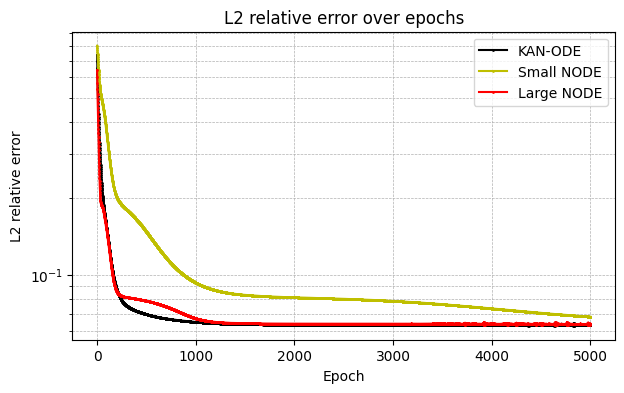

In [134]:
# L2 relative error:

plt.figure(figsize = (7, 4))

plt.plot(np.array(l2_errors_KANODE), label = 'KAN-ODE', marker = 'o', color = '0', markersize = 1)
plt.plot(np.array(l2_errors_NODE_small), label = 'Small NODE', marker = 'o', color = 'y', markersize = 1)
plt.plot(np.array(l2_errors_NODE_large), label = 'Large NODE', marker = 'o', color = 'r', markersize = 1)

plt.xlabel('Epoch')
plt.ylabel('L2 relative error')
plt.title('L2 relative error over epochs')
plt.yscale('log')
plt.legend()
plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5)
plt.show()

In [135]:
# Final L2 relative errors:

print(f"Final L2 relative error for the KAN-ODE : {l2_errors_KANODE[-1]:.3f}")
print(f"Final L2 relative error for the small NODE : {l2_errors_NODE_small[-1]:.3f}")
print(f"Final L2 relative error for the large NODE :  {l2_errors_NODE_large[-1]:.3f}")

Final L2 relative error for the KAN-ODE : 0.063
Final L2 relative error for the small NODE : 0.068
Final L2 relative error for the large NODE :  0.064


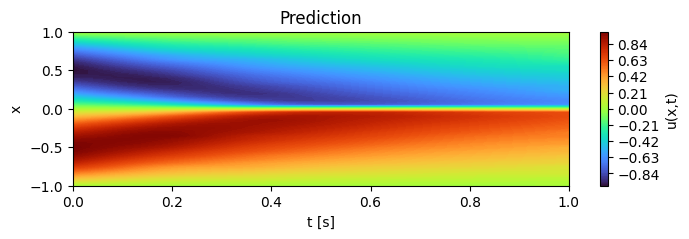

In [136]:
# Entire prediction:

u_pred = KANODE_model(t, u0)

plt.figure(figsize = (8, 2))

plt.contourf(t, x, u_pred.T, levels = 201, cmap = "turbo")
plt.colorbar(label = "u(x,t)")
plt.xlabel("t [s]")
plt.ylabel("x")
plt.title("Prediction")

plt.show()

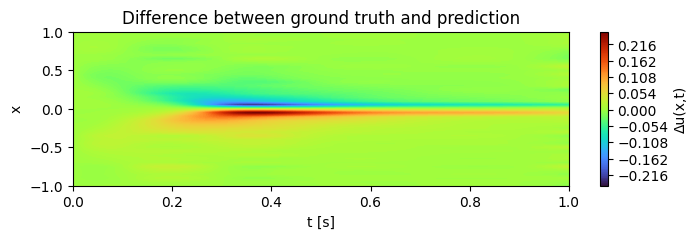

In [137]:
# Difference between ground truth and prediction:

plt.figure(figsize = (8, 2))

plt.contourf(t, x, usol - u_pred.T, levels = 201, cmap = "turbo")
plt.colorbar(label = "Δu(x,t)")
plt.xlabel("t [s]")
plt.ylabel("x")
plt.title("Difference between ground truth and prediction")

plt.show()

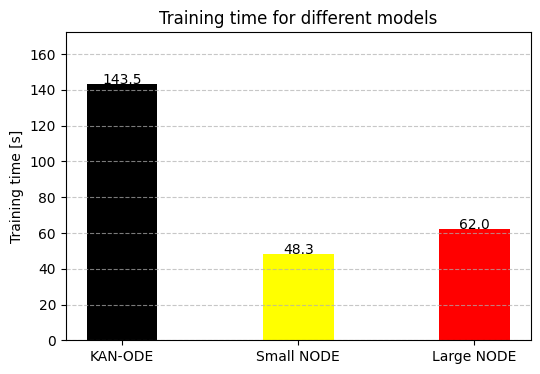

In [138]:
# Training times:

models = ["KAN-ODE", "Small NODE", "Large NODE"]
training_times = [143.5, 48.3, 62.0]

plt.figure(figsize=(6, 4))
plt.bar(models, training_times, color=['black', 'yellow', 'red'], width = 0.4)

plt.ylabel("Training time [s]")
plt.title("Training time for different models")
plt.ylim(0, max(training_times) * 1.2)
plt.grid(axis="y", linestyle="--", alpha=0.7)

for i, time in enumerate(training_times):
    plt.text(i, time + 0.002, f"{time:.1f}", ha="center", fontsize=10)

plt.show()

Saving burgers.mat to burgers (3).mat


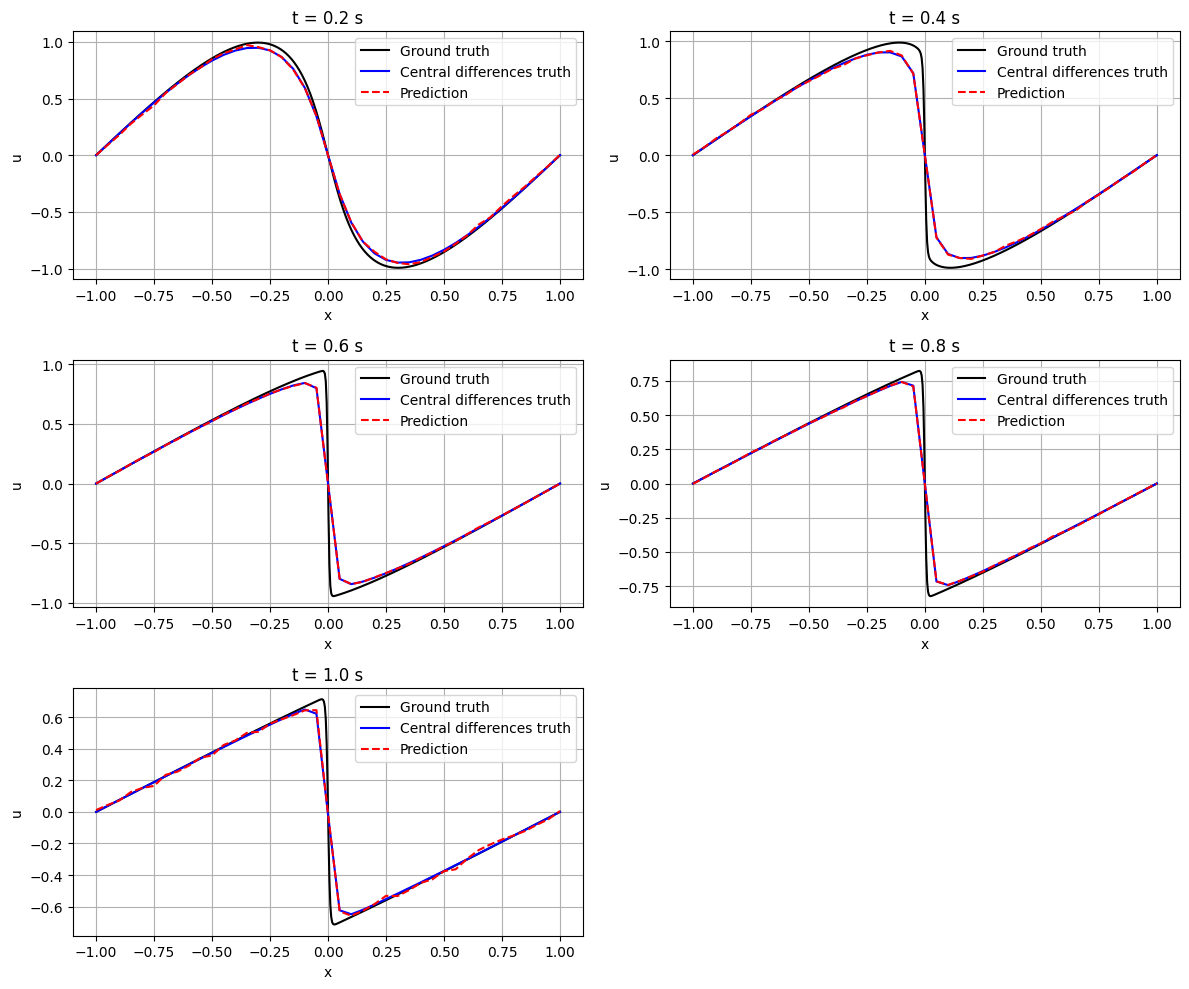

In [139]:
# Evaluation:

uploaded = files.upload()
data = scipy.io.loadmat('burgers.mat')

nu = data['nu'].item()
x = data['x'].squeeze()
t = data['t'].squeeze()
usol = data['usol'].T

t_test = jnp.array([0.2, 0.4, 0.6, 0.8, 1.0])
u_test = KANODE_model(t_test, u0)

plt.figure(figsize = (12, 10))

for i, time in enumerate(t_test):

    idx_gt = jnp.abs(t - time).argmin()
    ground_truth = usol[:, idx_gt]

    idx_cd = jnp.abs(tgrid - time).argmin()
    cd_truth = U[:, idx_cd]

    plt.subplot(3, 2, i + 1)
    plt.plot(x, ground_truth, label = "Ground truth", color = "0")
    plt.plot(xgrid, cd_truth, label = "Central differences truth", color = 'b')
    plt.plot(xgrid, u_test[i, :], label = "Prediction", color = "r", linestyle = "dashed")
    plt.xlabel("x")
    plt.ylabel("u")
    plt.title(f"t = {time:.1f} s")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()